In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from collections import Counter

# A

In [2]:
df = pd.read_csv("cleaned_data.csv")

df_labels = df["label"].copy()
df.drop(["label"], axis=1, inplace=True)

df.dropna(inplace=True)

numeric_cols = df.select_dtypes(include=np.number).columns
df_num = df[numeric_cols].copy()

scaler = StandardScaler()
X = scaler.fit_transform(df_num)

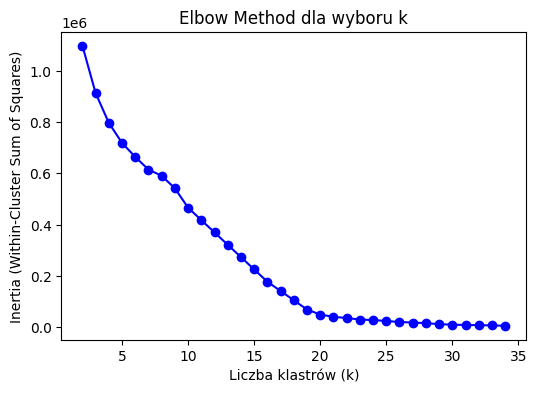

In [3]:
inertias = []
K_range = range(2, 35)

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init="auto")
    kmeans_temp.fit(X)
    inertias.append(kmeans_temp.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K_range, inertias, "bo-")
plt.xlabel("Liczba klastrów (k)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.title("Elbow Method dla wyboru k")
plt.show()

In [4]:
k_opt = 10
kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init="auto")
cluster_labels = kmeans.fit_predict(X)

In [5]:
df_clusters = pd.DataFrame(
    {
        "predicted_cluster": cluster_labels,
        "true_label": df_labels.values,  # oryginalna etykieta
    }
)

cluster_label_counts = df_clusters.groupby(["predicted_cluster", "true_label"]).size()
cluster_label_counts = cluster_label_counts.reset_index(name="count")

# print("Liczność (etykieta vs. klaster):")
# print(cluster_label_counts)

In [6]:
print("\nProcentowy udział etykiet w każdym klastrze:")
for c in sorted(df_clusters["predicted_cluster"].unique()):
    cluster_subset = df_clusters[df_clusters["predicted_cluster"] == c]
    total_in_cluster = len(cluster_subset)
    label_distribution = (
        cluster_subset["true_label"].value_counts() / total_in_cluster * 100
    )
    print(f"\nKlaster {c}:")
    print(label_distribution)


Procentowy udział etykiet w każdym klastrze:

Klaster 0:
true_label
Benign                       53.584084
PartOfAHorizontalPortScan    33.994343
C&C                          12.350054
DDoS                          0.045512
Okiru                         0.026007
Name: count, dtype: float64

Klaster 1:
true_label
Benign    100.0
Name: count, dtype: float64

Klaster 2:
true_label
Benign                       65.633691
PartOfAHorizontalPortScan    23.877632
Okiru                         6.158125
C&C                           4.330552
Name: count, dtype: float64

Klaster 3:
true_label
C&C       64.338843
Benign    35.661157
Name: count, dtype: float64

Klaster 4:
true_label
Attack                       71.183277
PartOfAHorizontalPortScan    19.690183
Benign                        8.286674
C&C                           0.802538
FileDownload                  0.037327
Name: count, dtype: float64

Klaster 5:
true_label
Benign    100.0
Name: count, dtype: float64

Klaster 6:
true_label
Benign 

### LocalOutlierFactor

In [7]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
y_pred_lof = lof.fit_predict(X)

lof_anomalies_mask = y_pred_lof == -1
print(f"\nWykrytych anomalii (LOF): {lof_anomalies_mask.sum()}")


Wykrytych anomalii (LOF): 481


In [8]:
df_anomalies_lof = df_clusters[lof_anomalies_mask]
anom_cluster_counts_lof = (
    df_anomalies_lof.groupby("predicted_cluster")
    .size()
    .reset_index(name="anomalies_count")
)
print("\nLiczba anomalii w poszczególnych klastrach (LOF):")
print(anom_cluster_counts_lof)


Liczba anomalii w poszczególnych klastrach (LOF):
   predicted_cluster  anomalies_count
0                  0               84
1                  1                1
2                  3               13
3                  4               22
4                  5               77
5                  6              241
6                  7               38
7                  8                5


In [9]:
lof_label_counts = (
    df_anomalies_lof.groupby("true_label").size().reset_index(name="anomaly_count")
)
print("\nRozkład etykiet wśród anomalii (LOF):")
print(lof_label_counts)


Rozkład etykiet wśród anomalii (LOF):
                  true_label  anomaly_count
0                     Attack              1
1                     Benign            399
2                        C&C             24
3                       DDoS              7
4                      Okiru              3
5  PartOfAHorizontalPortScan             47


### Isolation Forest

In [10]:
iso_forest = IsolationForest(contamination=0.01, random_state=42)
y_pred_iso = iso_forest.fit_predict(X)  # -1 oznacza anomalię

iso_anomalies_mask = y_pred_iso == -1
print(f"\nWykrytych anomalii (Isolation Forest): {iso_anomalies_mask.sum()}")


Wykrytych anomalii (Isolation Forest): 480


In [11]:
df_anomalies_iso = df_clusters[iso_anomalies_mask]
anom_cluster_counts_iso = (
    df_anomalies_iso.groupby("predicted_cluster")
    .size()
    .reset_index(name="anomalies_count")
)
print("\nLiczba anomalii w poszczególnych klastrach (Isolation Forest):")
print(anom_cluster_counts_iso)


Liczba anomalii w poszczególnych klastrach (Isolation Forest):
   predicted_cluster  anomalies_count
0                  0                9
1                  1                1
2                  3               21
3                  4               82
4                  5               90
5                  6              198
6                  7               61
7                  8                9
8                  9                9


In [12]:
iso_label_counts = (
    df_anomalies_iso.groupby("true_label").size().reset_index(name="anomaly_count")
)
print("\nRozkład etykiet wśród anomalii (Isolation Forest):")
print(iso_label_counts)


Rozkład etykiet wśród anomalii (Isolation Forest):
                  true_label  anomaly_count
0                     Attack              1
1                     Benign            377
2                        C&C             49
3                       DDoS             22
4               FileDownload              2
5  PartOfAHorizontalPortScan             29


# B

In [13]:
def purity_score(true_labels, cluster_labels):
    n = len(true_labels)

    df_temp = pd.DataFrame({"cluster": cluster_labels, "label": true_labels})

    group_counts = (
        df_temp.groupby(["cluster", "label"]).size().reset_index(name="count")
    )

    sum_max = 0
    for cluster in group_counts["cluster"].unique():
        cluster_group = group_counts[group_counts["cluster"] == cluster]
        max_count = cluster_group["count"].max()
        sum_max += max_count

    purity = sum_max / n
    return purity

In [14]:
df = pd.read_csv("cleaned_data.csv")

df_labels = df["label"].copy()
df.drop(["label"], axis=1, inplace=True)

df.dropna(inplace=True)

numeric_cols = df.select_dtypes(include=np.number).columns
df_num = df[numeric_cols].copy()

In [15]:
X_original = df_num.values

kmeans_orig = KMeans(n_clusters=k_opt, random_state=42, n_init="auto")
clusters_orig = kmeans_orig.fit_predict(X_original)

sil_original = silhouette_score(X_original, clusters_orig)
purity_original = purity_score(df_labels, clusters_orig)

print("====[ Oryginalne (nienormalizowane) ]====")
print(f"Silhouette Score = {sil_original:.3f}")
print(f"Purity          = {purity_original:.3f}\n")

====[ Oryginalne (nienormalizowane) ]====
Silhouette Score = 1.000
Purity          = 0.542



In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_num)

kmeans_scaled = KMeans(n_clusters=k_opt, random_state=42, n_init="auto")
clusters_scaled = kmeans_scaled.fit_predict(X_scaled)

sil_scaled = silhouette_score(X_scaled, clusters_scaled)
purity_scaled = purity_score(df_labels, clusters_scaled)

print("====[ Oryginalne -> Normalizowane ]====")
print(f"Silhouette Score = {sil_scaled:.3f}")
print(f"Purity          = {purity_scaled:.3f}\n")

====[ Oryginalne -> Normalizowane ]====
Silhouette Score = 0.922
Purity          = 0.628



In [17]:
pca_n_components = 3
pca_nonnorm = PCA(n_components=pca_n_components)
X_pca_nonnorm = pca_nonnorm.fit_transform(X_original)

kmeans_pca_nonnorm = KMeans(n_clusters=k_opt, random_state=42, n_init="auto")
clusters_pca_nonnorm = kmeans_pca_nonnorm.fit_predict(X_pca_nonnorm)

sil_pca_nonnorm = silhouette_score(X_pca_nonnorm, clusters_pca_nonnorm)
purity_pca_nonnorm = purity_score(df_labels, clusters_pca_nonnorm)

print("====[ PCA (nienormalizowane) ]====")
print(f"Silhouette Score = {sil_pca_nonnorm:.3f}")
print(f"Purity          = {purity_pca_nonnorm:.3f}\n")

====[ PCA (nienormalizowane) ]====
Silhouette Score = 1.000
Purity          = 0.542



In [18]:
pca = PCA(n_components=pca_n_components)
X_pca = pca.fit_transform(X_scaled)

kmeans_pca = KMeans(n_clusters=k_opt, random_state=42, n_init="auto")
clusters_pca = kmeans_pca.fit_predict(X_pca)

sil_pca = silhouette_score(X_pca, clusters_pca)
purity_pca = purity_score(df_labels, clusters_pca)

print("====[ PCA (po normalizacji) ]====")
print(f"Silhouette Score = {sil_pca:.3f}")
print(f"Purity          = {purity_pca:.3f}\n")

====[ PCA (po normalizacji) ]====
Silhouette Score = 0.980
Purity          = 0.611



# C

In [47]:
df = pd.read_csv("cleaned_data.csv")

df_labels = df["label"].copy()
df.drop(["label"], axis=1, inplace=True)

df.dropna(inplace=True)

numeric_cols = df.select_dtypes(include=np.number).columns
df_num = df[numeric_cols].copy()

In [51]:
df_sample = df_num.sample(n=100, random_state=42)
df_labels_sample = df_labels.loc[df_sample.index]

In [52]:
scaler = StandardScaler()
X_sample_scaled = scaler.fit_transform(df_sample)

X_scaled = scaler.fit_transform(df_num)

df_sample_scaled = pd.DataFrame(
    X_sample_scaled, index=df_sample.index, columns=df_sample.columns
)

df_scaled = pd.DataFrame(
    X_scaled, index=df_num.index, columns=df_num.columns
)

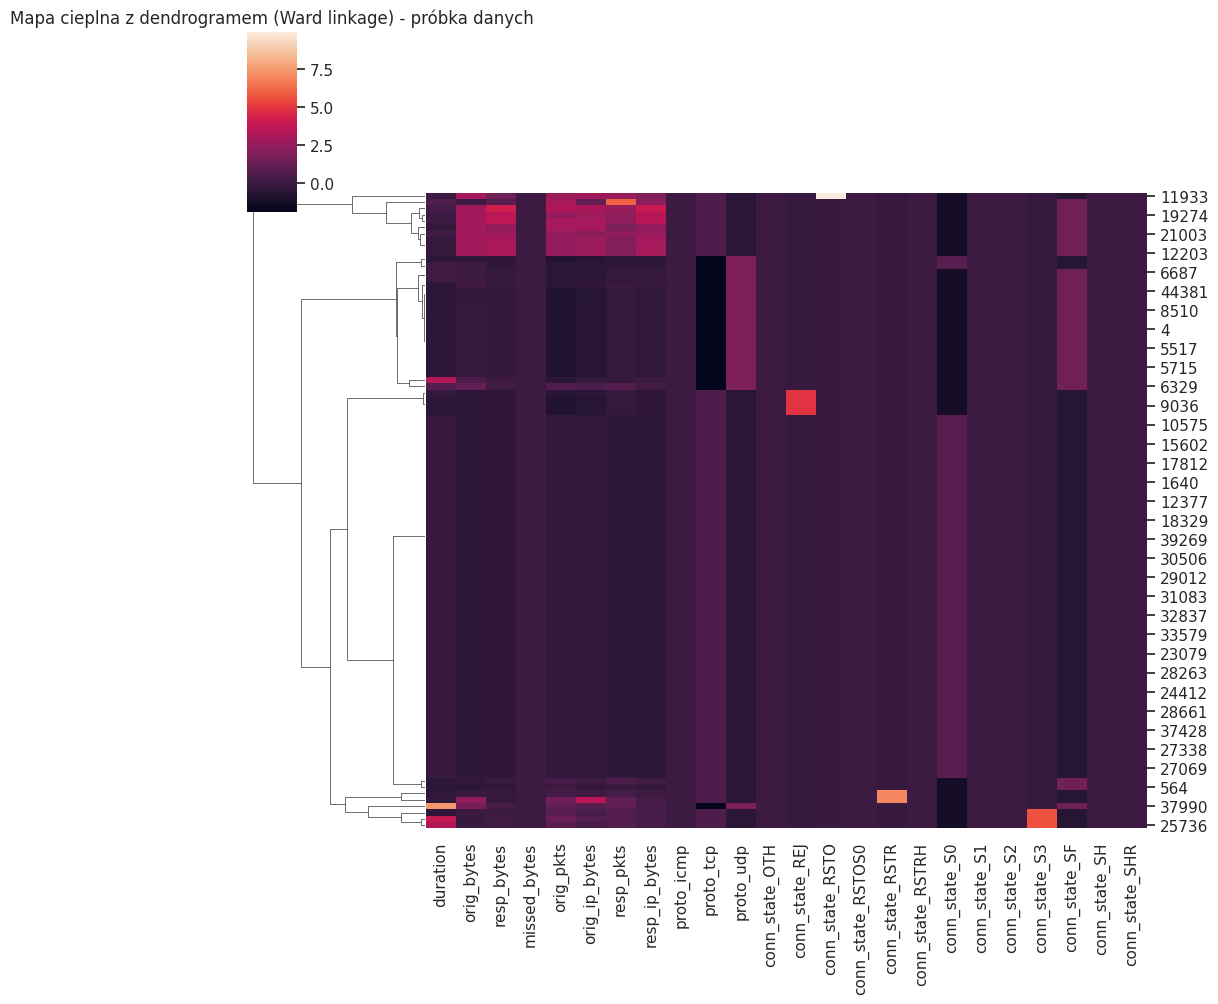

In [53]:
sns.set_theme(style="white")
g = sns.clustermap(
    df_sample_scaled,
    method="ward",
    metric="euclidean",
    col_cluster=False,
    figsize=(10, 10),
)
plt.title("Mapa cieplna z dendrogramem (Ward linkage) - próbka danych")
plt.show()

In [54]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample_scaled)

In [55]:
def biplot(scores, loadings, feature_names, labels=None):
    fig, ax = plt.subplots(figsize=(8, 6))

    if labels is not None:
        unique_labels = pd.unique(labels)
        palette = sns.color_palette("hls", len(unique_labels))
        label_color_map = dict(zip(unique_labels, palette))

        for lbl in unique_labels:
            mask = labels == lbl
            ax.scatter(
                scores[mask, 0],
                scores[mask, 1],
                label=lbl,
                s=20,
                alpha=0.6,
                c=[label_color_map[lbl]],
            )
        ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    else:
        ax.scatter(scores[:, 0], scores[:, 1], s=20, alpha=0.6)

    n_features = loadings.shape[0]
    for i in range(n_features):
        x = loadings[i, 0] * 2.5  
        y = loadings[i, 1] * 2.5
        ax.arrow(0, 0, x, y, color="r", alpha=0.5, head_width=0.03)
        ax.text(x * 1.1, y * 1.1, feature_names[i], color="r", fontsize=9)

    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title("Biplot PCA (2 składniki)")
    plt.grid(True)
    plt.show()

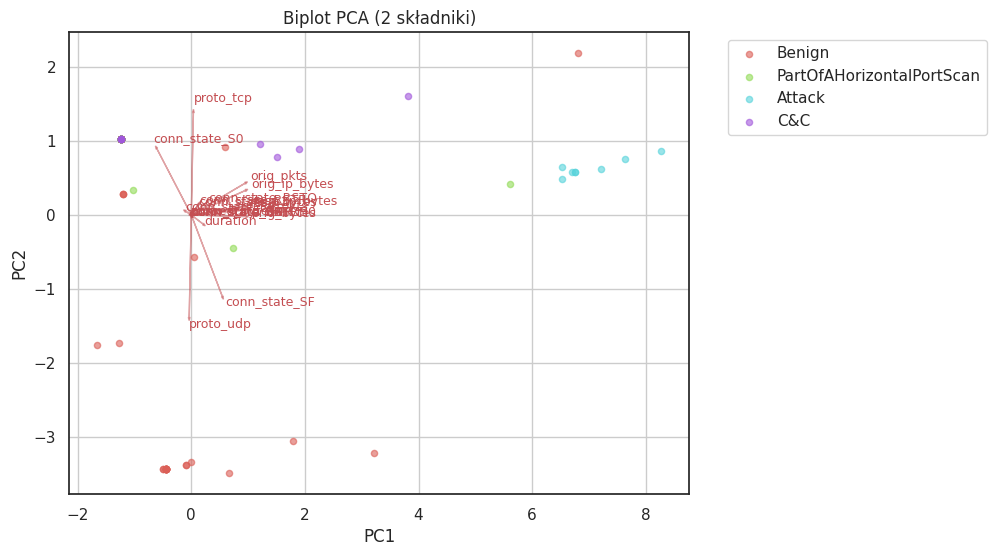

In [56]:
loadings = pca.components_.T
feature_names = df_sample.columns
biplot(X_pca, loadings, feature_names, labels=df_labels_sample.values)